In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from PIL import Image
from tqdm import tqdm

from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Multimodal pair dataset
class MultiModalDataset(Dataset):
    def __init__(self, pairs_csv, transform=None):
        self.data = pd.read_csv(pairs_csv)
        self.transform = transform

    # 3 images per pair
    def __len__(self):
        return len(self.data) // 3

    def __getitem__(self, idx):
        start_idx = idx * 3
        pair_data = self.data.iloc[start_idx:start_idx + 3]

        images = []
        label = pair_data.iloc[0]['label']
        
        for _, row in pair_data.iterrows():
            image_path = row['file']
            image = Image.open(image_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            images.append(image)
        
        combined_images = torch.stack(images)

        # add text info
        ocr_values = []
        for _, row in pair_data.iterrows():
            ocr_info = row[['region_1','region_2','region_3','region_4','region_5','region_6']].values
            ocr_numeric = []
            for value in ocr_info:
                try:
                    if isinstance(value, str):
                        value = value.replace('I', '1').replace('"', '')
                        if 'K' in value:
                            value = float(value.replace('K', ''))
                    ocr_numeric.append(float(value))
                except ValueError:
                    ocr_numeric.append(0.0)
            ocr_values.append(ocr_numeric)
        
        ocr_tensor = torch.tensor(ocr_values, dtype=torch.float32).mean(dim=0)
        return combined_images, ocr_tensor, label

In [3]:
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_ratio, stride, kernel_size, se_ratio=0.25):
        super(MBConvBlock, self).__init__()
        self.stride = stride
        mid_channels = in_channels * expansion_ratio

        self.expansion = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels, momentum=0.99)
        self.act1 = nn.SiLU()

        self.depthwise = nn.Conv2d(mid_channels, mid_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=mid_channels, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels, momentum=0.99)
        self.act2 = nn.SiLU()

        se_channels = max(1, int(in_channels * se_ratio))
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(mid_channels, se_channels, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(se_channels, mid_channels, kernel_size=1),
            nn.Sigmoid()
        )

        self.projection = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels, momentum=0.99)

        self.apply_residual = (in_channels == out_channels) and (stride == 1)

    def forward(self, x):
        residual = x
        x = self.expansion(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.depthwise(x)
        x = self.bn2(x)
        x = self.act2(x)

        weights = self.se(x)
        x = x * weights

        x = self.projection(x)
        x = self.bn3(x)

        if self.apply_residual:
            x = x + residual
        
        return x

In [4]:
# image classifier to extract image features
class EfficientNetLSTM(nn.Module):
    def __init__(self, num_classes=2, lstm_hidden_size=256, num_lstm_layers=2, dropout_prob=0.2):
        super(EfficientNetLSTM, self).__init__()
        base_channels = 32

        self.stage_1 = nn.Sequential(
            nn.Conv2d(3, base_channels, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_channels, momentum=0.99),
            nn.SiLU(),
            nn.Dropout(dropout_prob)
        )

        stages = [
            [32, 16, 1, 1, 3, 1],
            [16, 24, 2, 2, 3, 6],
            [24, 40, 2, 2, 5, 6],
            [40, 80, 3, 2, 3, 6],
            [80, 112, 3, 1, 5, 6],
            [112, 192, 4, 2, 5, 6],
            [192, 320, 1, 1, 3, 6]
        ]

        layers = []
        in_channels_last = base_channels
        for in_channels, out_channels, num_blocks, stride, kernel_size, expansion_ratio in stages:
            for i in range(num_blocks):
                layers.append(MBConvBlock(
                    in_channels_last, 
                    out_channels, 
                    expansion_ratio, 
                    stride if i == 0 else 1, 
                    kernel_size))
                in_channels_last = out_channels

        self.mbconv_stages = nn.Sequential(*layers)

        self.stage_9 = nn.Sequential(
            nn.Conv2d(in_channels_last, 1280, kernel_size=1, bias=False),
            nn.BatchNorm2d(1280, momentum=0.99),
            nn.SiLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Dropout(dropout_prob)
        )

        self.lstm = nn.LSTM(
            input_size=1280, 
            hidden_size=lstm_hidden_size, 
            num_layers=num_lstm_layers, 
            batch_first=True, 
            bidirectional=False,
            dropout=dropout_prob if num_lstm_layers > 1 else 0.0
        )

        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    # extract feature vectors from the model for mulitmodal model
    def forward_features(self, x):
        # x: [batch, seq_len, C, H, W]
        batch_size, seq_len, C, H, W = x.size()
        x = x.view(batch_size * seq_len, C, H, W)
        x = self.stage_1(x)
        x = self.mbconv_stages(x)
        x = self.stage_9(x)
        x = x.flatten(start_dim=1)
        x = x.view(batch_size, seq_len, -1)
        lstm_out, (hidden, cell) = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        return last_output

    def forward(self, x):
        features = self.forward_features(x)
        # if want to forward, just pass the features to the fc layer
        out = self.fc(features)
        return out


In [5]:
# text classifier to extract text features
class OCRClassifier(nn.Module):
    def __init__(self, input_size=6, hidden_size=128, num_classes=2, dropout_prob=0.2):
        super(OCRClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size // 2, num_classes)
        )

    # extract feature vectors from the model for mulitmodal model
    def forward_features(self, ocr_data):
        x = self.fc[0](ocr_data)  
        x = self.fc[1](x)         
        x = self.fc[2](x)         
        x = self.fc[3](x)         
        x = self.fc[4](x)         
        x = self.fc[5](x)         
        return x

    def forward(self, ocr_data):
        # if want to forward, just pass the features to the fc layer
        return self.fc(ocr_data)

In [6]:
# multimodal classifier
class MultiModalClassifier(nn.Module):
    def __init__(self, image_model: EfficientNetLSTM, text_model: OCRClassifier, num_classes=2, freeze_image=False):
        super(MultiModalClassifier, self).__init__()
        self.image_model = image_model
        self.text_model = text_model

        # embedding dimension for image and text
        img_embed_dim = 256
        txt_embed_dim = 64 

        # 64 -> 256 for text
        self.txt_proj = nn.Linear(txt_embed_dim, img_embed_dim)

        # calculate weights foor each modality
        self.img_gate = nn.Linear(img_embed_dim + txt_embed_dim, 1)
        self.txt_gate = nn.Linear(img_embed_dim + txt_embed_dim, 1)

        self.img_gate.bias.data.fill_(0.8)  
        self.txt_gate.bias.data.fill_(0.2)  

        self.classifier = nn.Linear(img_embed_dim, num_classes)

    def forward(self, images, ocr_data):
        # get img embedding -> [batch, 256]
        img_features = self.image_model.forward_features(images)

        # get text embedding -> [batch, 64]
        txt_hidden = self.text_model.forward_features(ocr_data) 

        # concatenate image and text features -> [batch, 320]
        combined = torch.cat([img_features, txt_hidden], dim=1) 

        # calculate weights -> [batch, 1]
        img_weight = self.img_gate(combined) 
        txt_weight = self.txt_gate(combined) 

        # concatenate weights -> [batch, 2]
        weights = torch.cat([img_weight, txt_weight], dim=1) 
        weights = torch.softmax(weights, dim=1)

        # proejcting text features to 256 dim
        txt_features_proj = self.txt_proj(txt_hidden)

        # fuse
        fused = img_features * weights[:,0:1] + txt_features_proj * weights[:,1:2]

        # classify
        out = self.classifier(fused)
        return out

In [7]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, path='./weights/best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.path = path
    
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            print(f"Validation loss decreased ({self.best_loss:.4f} -> {val_loss:.4f}). Saving model...")
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
    
    def save_checkpoint(self, val_loss, model):        
        torch.save(model.state_dict(), self.path)


In [8]:
def train(model, train_loader, val_loader, criterion, device, weight_name, num_epochs=100, patience=10, image_lr=1e-5, text_lr=1e-3, weight_decay=1e-4, scheduler=None):

    # separate image and text parameters
    image_params = []
    text_params = []
    for name, param in model.named_parameters():
        if 'image_model' in name:
            image_params.append(param)
        else:
            text_params.append(param)

    # optimiser for image and text parameters
    optimizer = optim.AdamW([
        {'params': image_params, 'lr': image_lr},  
        {'params': text_params, 'lr': text_lr}      
    ], weight_decay=weight_decay)


    early_stopping = EarlyStopping(patience=patience, verbose=True, path=f'weights/best_{weight_name}.pth')

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 30)

        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, ocr_data, labels in tqdm(train_loader, desc="Training"):
            images, ocr_data, labels = images.to(device), ocr_data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, ocr_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss /= total_train
        train_acc = correct_train / total_train * 100
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)

        print(f"Training loss: {train_loss:.4f}, accuracy: {train_acc:.2f}%")

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, ocr_data, labels in tqdm(val_loader, desc="Validation"):
                images, ocr_data, labels = images.to(device), ocr_data.to(device), labels.to(device)
                outputs = model(images, ocr_data)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= total_val
        val_acc = correct_val / total_val * 100
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        print(f"Validation loss: {val_loss:.4f}, accuracy: {val_acc:.2f}%")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load(f'weights/best_{weight_name}.pth'))
    print("Training completed and the best model is loaded.")
    return model, history


In [9]:
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, ocr_data, labels in tqdm(test_loader, desc="Testing"):
            images, ocr_data, labels = images.to(device), ocr_data.to(device), labels.to(device)
            outputs = model(images, ocr_data)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
    
    test_loss /= total_test
    test_accuracy = 100 * correct_test / total_test
    print(f"Test loss: {test_loss:.4f}, accuracy: {test_accuracy:.2f}%")
    return test_loss, test_accuracy


In [9]:
def plot_history(history, save_path=None):

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # loss graph
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title('Loss Over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # accuracy graph
    axes[1].plot(history['train_acc'], label='Train Accuracy')
    axes[1].plot(history['val_acc'], label='Validation Accuracy')
    axes[1].set_title('Accuracy Over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}_combined.png")
    plt.show()

    # save individual plots
    # trian loss
    plt.figure(figsize=(7, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.title('Train Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(f"{save_path}_train_loss.png")
    plt.show()

    # validation loss
    plt.figure(figsize=(7, 5))
    plt.plot(history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(f"{save_path}_val_loss.png")
    plt.show()

    # train accuracy
    plt.figure(figsize=(7, 5))
    plt.plot(history['train_acc'], label='Train Accuracy', color='green')
    plt.title('Train Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(f"{save_path}_train_acc.png")
    plt.show()

    # validation accuracy
    plt.figure(figsize=(7, 5))
    plt.plot(history['val_acc'], label='Validation Accuracy', color='red')
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    if save_path:
        plt.savefig(f"{save_path}_val_acc.png")
    plt.show()

In [11]:
train_csv = './data/maksed_frame_split_by_match_pair_ocr/train/pairs.csv'
val_csv = './data/maksed_frame_split_by_match_pair_ocr/val/pairs.csv'
test_csv = './data/maksed_frame_split_by_match_pair_ocr/test/pairs.csv'

transform = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 4
train_dataset = MultiModalDataset(train_csv, transform=transform)
val_dataset = MultiModalDataset(val_csv, transform=transform)
test_dataset = MultiModalDataset(test_csv, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
image_model = EfficientNetLSTM(num_classes=2).to(device)
text_model = OCRClassifier(input_size=6, hidden_size=128, num_classes=2).to(device)
model = MultiModalClassifier(image_model, text_model, num_classes=2, freeze_image=False).to(device)

criterion = nn.CrossEntropyLoss()

weight_name = "multimodal"
num_epochs = 50
patience = 3

image_lr = 1e-5
text_lr = 1e-5
weight_decay = 1e-4

model, history = train(model=model, 
                       train_loader=train_loader, 
                       val_loader=val_loader, 
                       criterion=criterion,
                       device=device,
                       weight_name=weight_name, 
                       num_epochs=num_epochs, 
                       patience=patience, 
                       image_lr=image_lr, 
                       text_lr=text_lr, 
                       weight_decay=weight_decay)


Epoch 1/50
------------------------------


Training:   0%|          | 0/3121 [00:00<?, ?it/s]

Training: 100%|██████████| 3121/3121 [19:35<00:00,  2.66it/s]


Training loss: 0.6324, accuracy: 64.51%


Validation: 100%|██████████| 94/94 [00:29<00:00,  3.14it/s]


Validation loss: 0.4928, accuracy: 90.40%
Validation loss decreased (inf -> 0.4928). Saving model...
Epoch 2/50
------------------------------


Training: 100%|██████████| 3121/3121 [19:30<00:00,  2.67it/s]


Training loss: 0.5004, accuracy: 76.26%


Validation: 100%|██████████| 94/94 [00:29<00:00,  3.14it/s]


Validation loss: 0.3697, accuracy: 88.80%
Validation loss decreased (0.4928 -> 0.3697). Saving model...
Epoch 3/50
------------------------------


Training: 100%|██████████| 3121/3121 [19:31<00:00,  2.66it/s]


Training loss: 0.4380, accuracy: 79.70%


Validation: 100%|██████████| 94/94 [00:29<00:00,  3.13it/s]


Validation loss: 0.3306, accuracy: 86.13%
Validation loss decreased (0.3697 -> 0.3306). Saving model...
Epoch 4/50
------------------------------


Training: 100%|██████████| 3121/3121 [19:30<00:00,  2.67it/s]


Training loss: 0.4117, accuracy: 81.06%


Validation: 100%|██████████| 94/94 [00:30<00:00,  3.11it/s]


Validation loss: 0.3057, accuracy: 86.13%
Validation loss decreased (0.3306 -> 0.3057). Saving model...
Epoch 5/50
------------------------------


Training: 100%|██████████| 3121/3121 [19:31<00:00,  2.66it/s]


Training loss: 0.3973, accuracy: 81.65%


Validation: 100%|██████████| 94/94 [00:30<00:00,  3.13it/s]


Validation loss: 0.2970, accuracy: 86.13%
Validation loss decreased (0.3057 -> 0.2970). Saving model...
Epoch 6/50
------------------------------


Training: 100%|██████████| 3121/3121 [19:36<00:00,  2.65it/s]


Training loss: 0.3856, accuracy: 82.70%


Validation: 100%|██████████| 94/94 [00:31<00:00,  2.98it/s]


Validation loss: 0.2818, accuracy: 87.47%
Validation loss decreased (0.2970 -> 0.2818). Saving model...
Epoch 7/50
------------------------------


Training: 100%|██████████| 3121/3121 [19:55<00:00,  2.61it/s]


Training loss: 0.3782, accuracy: 82.45%


Validation: 100%|██████████| 94/94 [00:33<00:00,  2.84it/s]


Validation loss: 0.2773, accuracy: 86.40%
Validation loss decreased (0.2818 -> 0.2773). Saving model...
Epoch 8/50
------------------------------


Training: 100%|██████████| 3121/3121 [20:43<00:00,  2.51it/s]


Training loss: 0.3765, accuracy: 83.21%


Validation: 100%|██████████| 94/94 [00:30<00:00,  3.13it/s]


Validation loss: 0.2775, accuracy: 86.40%
EarlyStopping counter: 1 out of 3
Epoch 9/50
------------------------------


Training: 100%|██████████| 3121/3121 [19:35<00:00,  2.65it/s]


Training loss: 0.3641, accuracy: 83.74%


Validation: 100%|██████████| 94/94 [00:30<00:00,  3.11it/s]


Validation loss: 0.2775, accuracy: 86.13%
EarlyStopping counter: 2 out of 3
Epoch 10/50
------------------------------


Training: 100%|██████████| 3121/3121 [19:32<00:00,  2.66it/s]


Training loss: 0.3600, accuracy: 83.81%


Validation: 100%|██████████| 94/94 [00:30<00:00,  3.11it/s]


Validation loss: 0.2705, accuracy: 86.67%
Validation loss decreased (0.2773 -> 0.2705). Saving model...
Epoch 11/50
------------------------------


Training: 100%|██████████| 3121/3121 [19:31<00:00,  2.66it/s]


Training loss: 0.3599, accuracy: 83.76%


Validation: 100%|██████████| 94/94 [00:30<00:00,  3.10it/s]


Validation loss: 0.2674, accuracy: 87.20%
Validation loss decreased (0.2705 -> 0.2674). Saving model...
Epoch 12/50
------------------------------


Training: 100%|██████████| 3121/3121 [19:31<00:00,  2.67it/s]


Training loss: 0.3524, accuracy: 83.92%


Validation: 100%|██████████| 94/94 [00:30<00:00,  3.13it/s]


Validation loss: 0.2736, accuracy: 86.40%
EarlyStopping counter: 1 out of 3
Epoch 13/50
------------------------------


Training: 100%|██████████| 3121/3121 [19:33<00:00,  2.66it/s]


Training loss: 0.3518, accuracy: 84.10%


Validation: 100%|██████████| 94/94 [00:30<00:00,  3.12it/s]


Validation loss: 0.2636, accuracy: 86.40%
Validation loss decreased (0.2674 -> 0.2636). Saving model...
Epoch 14/50
------------------------------


Training: 100%|██████████| 3121/3121 [19:31<00:00,  2.66it/s]


Training loss: 0.3442, accuracy: 84.65%


Validation: 100%|██████████| 94/94 [00:30<00:00,  3.11it/s]


Validation loss: 0.2605, accuracy: 87.73%
Validation loss decreased (0.2636 -> 0.2605). Saving model...
Epoch 15/50
------------------------------


Training: 100%|██████████| 3121/3121 [19:35<00:00,  2.66it/s]


Training loss: 0.3404, accuracy: 84.51%


Validation: 100%|██████████| 94/94 [00:30<00:00,  3.12it/s]


Validation loss: 0.2628, accuracy: 86.40%
EarlyStopping counter: 1 out of 3
Epoch 16/50
------------------------------


Training: 100%|██████████| 3121/3121 [20:00<00:00,  2.60it/s]


Training loss: 0.3386, accuracy: 84.59%


Validation: 100%|██████████| 94/94 [00:30<00:00,  3.06it/s]


Validation loss: 0.2609, accuracy: 86.40%
EarlyStopping counter: 2 out of 3
Epoch 17/50
------------------------------


Training: 100%|██████████| 3121/3121 [20:07<00:00,  2.59it/s]


Training loss: 0.3397, accuracy: 84.32%


Validation: 100%|██████████| 94/94 [00:30<00:00,  3.05it/s]


Validation loss: 0.2589, accuracy: 86.40%
Validation loss decreased (0.2605 -> 0.2589). Saving model...
Epoch 18/50
------------------------------


Training: 100%|██████████| 3121/3121 [37:08<00:00,  1.40it/s]


Training loss: 0.3359, accuracy: 84.38%


Validation: 100%|██████████| 94/94 [01:12<00:00,  1.30it/s]


Validation loss: 0.2612, accuracy: 86.40%
EarlyStopping counter: 1 out of 3
Epoch 19/50
------------------------------


Training: 100%|██████████| 3121/3121 [40:45<00:00,  1.28it/s]


Training loss: 0.3362, accuracy: 84.45%


Validation: 100%|██████████| 94/94 [01:11<00:00,  1.31it/s]


Validation loss: 0.2586, accuracy: 87.20%
Validation loss decreased (0.2589 -> 0.2586). Saving model...
Epoch 20/50
------------------------------


Training: 100%|██████████| 3121/3121 [40:19<00:00,  1.29it/s]


Training loss: 0.3335, accuracy: 84.62%


Validation: 100%|██████████| 94/94 [01:11<00:00,  1.31it/s]


Validation loss: 0.2622, accuracy: 86.67%
EarlyStopping counter: 1 out of 3
Epoch 21/50
------------------------------


Training: 100%|██████████| 3121/3121 [40:21<00:00,  1.29it/s]


Training loss: 0.3288, accuracy: 85.09%


Validation: 100%|██████████| 94/94 [01:09<00:00,  1.35it/s]


Validation loss: 0.2580, accuracy: 86.40%
Validation loss decreased (0.2586 -> 0.2580). Saving model...
Epoch 22/50
------------------------------


Training: 100%|██████████| 3121/3121 [30:56<00:00,  1.68it/s]


Training loss: 0.3276, accuracy: 85.23%


Validation: 100%|██████████| 94/94 [00:40<00:00,  2.32it/s]


Validation loss: 0.2493, accuracy: 87.20%
Validation loss decreased (0.2580 -> 0.2493). Saving model...
Epoch 23/50
------------------------------


Training: 100%|██████████| 3121/3121 [24:35<00:00,  2.12it/s]


Training loss: 0.3295, accuracy: 84.90%


Validation: 100%|██████████| 94/94 [00:31<00:00,  3.02it/s]


Validation loss: 0.2535, accuracy: 87.20%
EarlyStopping counter: 1 out of 3
Epoch 24/50
------------------------------


Training: 100%|██████████| 3121/3121 [20:01<00:00,  2.60it/s]


Training loss: 0.3280, accuracy: 84.57%


Validation: 100%|██████████| 94/94 [00:30<00:00,  3.11it/s]


Validation loss: 0.2529, accuracy: 87.47%
EarlyStopping counter: 2 out of 3
Epoch 25/50
------------------------------


Training: 100%|██████████| 3121/3121 [19:59<00:00,  2.60it/s]


Training loss: 0.3233, accuracy: 84.91%


Validation: 100%|██████████| 94/94 [00:30<00:00,  3.06it/s]

Validation loss: 0.2548, accuracy: 86.67%
EarlyStopping counter: 3 out of 3
Early stopping
Training completed and the best model is loaded.



/tmp/ipykernel_343075/3564159510.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'weights/best_{weight_name}.pth'))


In [16]:
test_loss, test_accuracy = test(model, test_loader, criterion, device)

Testing: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]

Test loss: 0.3582, accuracy: 82.10%


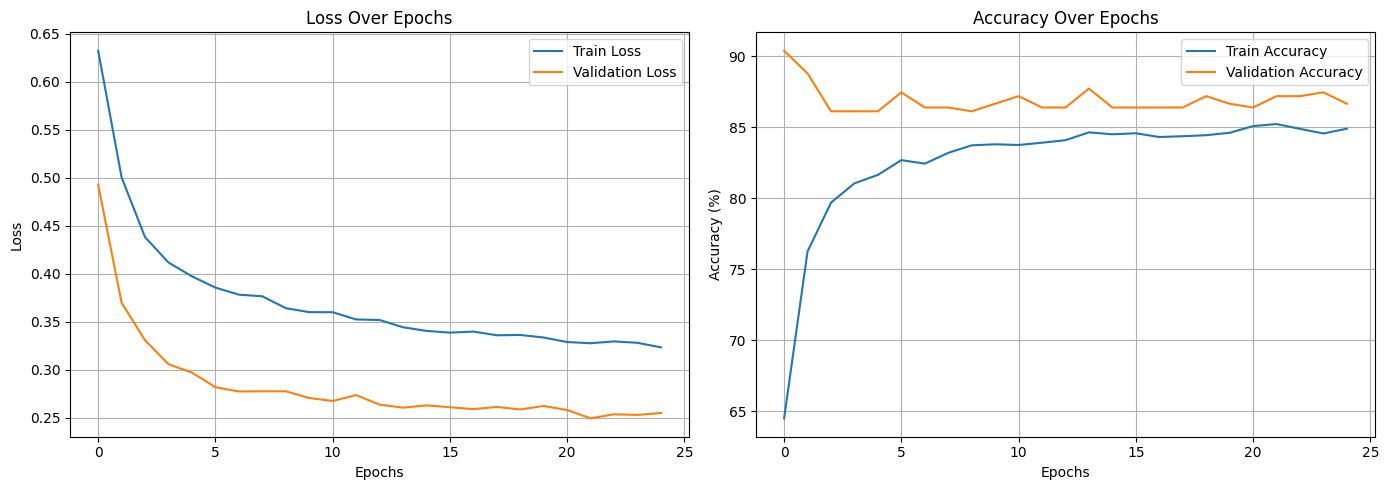

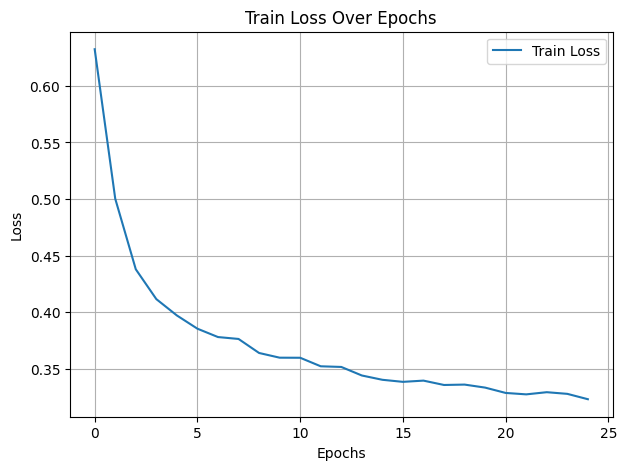

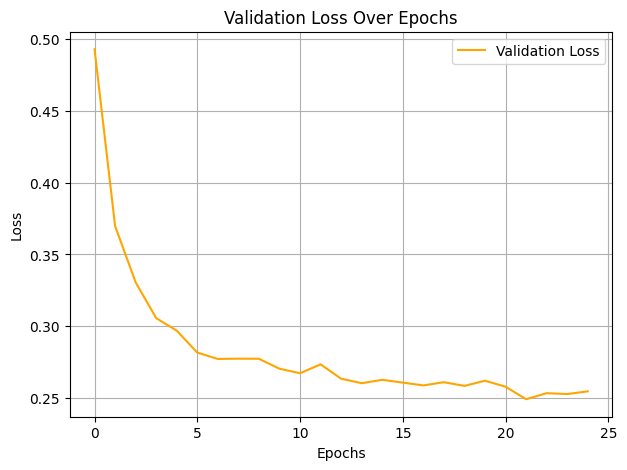

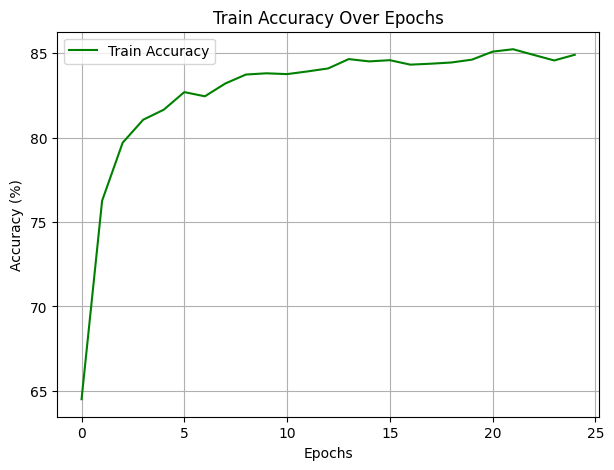

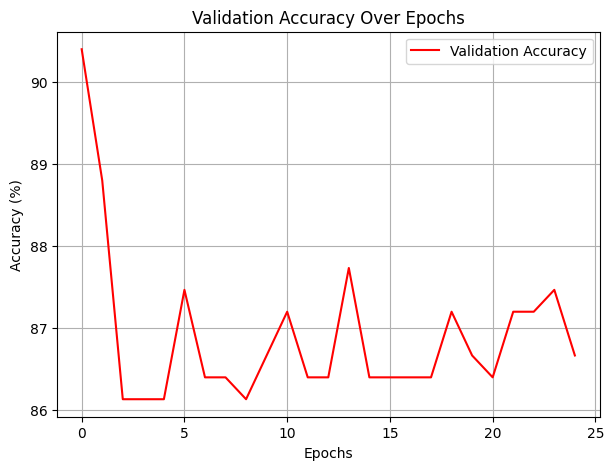

In [21]:
plot_history(history, save_path='./graphs/multimodal_results')

In [ ]:
# check misclassified pairs

In [22]:
class MultiModalDataset(Dataset):
    def __init__(self, pairs_csv, transform=None):
        self.data = pd.read_csv(pairs_csv)
        self.transform = transform

    def __len__(self):
        return len(self.data) // 3

    def __getitem__(self, idx):
        start_idx = idx * 3
        pair_data = self.data.iloc[start_idx:start_idx + 3]

        images = []
        label = pair_data.iloc[0]['label']
        
        for _, row in pair_data.iterrows():
            image_path = row['file']
            image = Image.open(image_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            images.append(image)
        
        combined_images = torch.stack(images)

        
        ocr_values = []
        for _, row in pair_data.iterrows():
            ocr_info = row[['region_1','region_2','region_3','region_4','region_5','region_6']].values
            ocr_numeric = []
            for value in ocr_info:
                try:
                    if isinstance(value, str):
                        value = value.replace('I', '1').replace('"', '')
                        if 'K' in value:
                            value = float(value.replace('K', ''))
                    ocr_numeric.append(float(value))
                except ValueError:
                    ocr_numeric.append(0.0)
            ocr_values.append(ocr_numeric)
        
        ocr_tensor = torch.tensor(ocr_values, dtype=torch.float32).mean(dim=0)

        # add file names
        files = pair_data['file'].values.tolist()
        
        return combined_images, ocr_tensor, label, files


In [23]:
train_csv = './data/maksed_frame_split_by_match_pair_ocr/train/pairs.csv'
val_csv = './data/maksed_frame_split_by_match_pair_ocr/val/pairs.csv'
test_csv = './data/maksed_frame_split_by_match_pair_ocr/test/pairs.csv'

transform = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 4
train_dataset = MultiModalDataset(train_csv, transform=transform)
val_dataset = MultiModalDataset(val_csv, transform=transform)
test_dataset = MultiModalDataset(test_csv, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
def print_misclassified(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    misclassified_pairs = []

    with torch.no_grad():
        for images, ocr_data, labels, files in tqdm(test_loader, desc="Testing"):
            images, ocr_data, labels = images.to(device), ocr_data.to(device), labels.to(device)
            outputs = model(images, ocr_data)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

            # record misclassified pairs
            for i in range(labels.size(0)):
                if predicted[i] != labels[i]:
                    
                    misclassified_pairs.append(files) 

    test_loss /= total_test
    test_accuracy = 100 * correct_test / total_test
    print(f"Test loss: {test_loss:.4f}, accuracy: {test_accuracy:.2f}%")

    if misclassified_pairs:
        print("Misclassified Pairs:")
        for i, pair_files in enumerate(misclassified_pairs, start=1):
            print(f"{i}. {pair_files}")
    else:
        print("No misclassified pairs.")

    return test_loss, test_accuracy


In [25]:
print_misclassified(model, test_loader, criterion, device)

Testing: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]

Test loss: 0.3582, accuracy: 82.10%
Misclassified Pairs:
1. [('./data/maksed_frame_split_by_match_pair_ocr/test/104/104_pair_5_early.jpg', './data/maksed_frame_split_by_match_pair_ocr/test/104/104_pair_6_early.jpg', './data/maksed_frame_split_by_match_pair_ocr/test/104/104_pair_7_early.jpg', './data/maksed_frame_split_by_match_pair_ocr/test/104/104_pair_8_early.jpg'), ('./data/maksed_frame_split_by_match_pair_ocr/test/104/104_pair_5_mid.jpg', './data/maksed_frame_split_by_match_pair_ocr/test/104/104_pair_6_mid.jpg', './data/maksed_frame_split_by_match_pair_ocr/test/104/104_pair_7_mid.jpg', './data/maksed_frame_split_by_match_pair_ocr/test/104/104_pair_8_mid.jpg'), ('./data/maksed_frame_split_by_match_pair_ocr/test/104/104_pair_5_late.jpg', './data/maksed_frame_split_by_match_pair_ocr/test/104/104_pair_6_late.jpg', './data/maksed_frame_split_by_match_pair_ocr/test/104/104_pair_7_late.jpg', './data/maksed_frame_split_by_match_pair_ocr/test/104/104_pair_8_late.jpg')]
2. [('./data/maksed_f

(0.35819162755175626, 82.09718670076727)